In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from apyori import apriori
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

### Conjunto de datos

Se usa el conjunto de datos publicado en el portal de trámites del estado que está en https://datos.gob.bo/dataset/tramites-estado.
El presente conjunto de datos, muestra los trámites de las distintas instituciones del Estado registradas hasta la fecha en el Portal Único de Trámites https://gob.bo.

Se tienen los siguientes objetivos:

- Resumir algunos datos usando gráficos que ayuden a visualizar comportamientos.
- Encontrar reglas de asociación en las categorías a las que pertenecen los trámites.

In [88]:
# Cargando el conjunto de datos
tramites = pd.read_csv('tramites_rev.csv', sep='|')
tramites.shape

(1029, 43)

In [90]:
tramites.head()

id_entidad                        denominacion    sigla  codigo  \
0         449                       Pro – Bolivia  PRO-BOL     NaN   
1          32  Ministerio de Educación de Bolivia   MINEDU     NaN   
2          32  Ministerio de Educación de Bolivia   MINEDU     NaN   
3          32  Ministerio de Educación de Bolivia   MINEDU     NaN   
4          32  Ministerio de Educación de Bolivia   MINEDU     NaN   

                                    objetivo_entidad      url_sitio_web  \
0                                                NaN                NaN   
1  Diseñar, implementar y ejecutar políticas, est...  www.minedu.gob.bo   
2  Diseñar, implementar y ejecutar políticas, est...  www.minedu.gob.bo   
3  Diseñar, implementar y ejecutar políticas, est...  www.minedu.gob.bo   
4  Diseñar, implementar y ejecutar políticas, est...  www.minedu.gob.bo   

                            horario_atencion_entidad  \
0  {"segundo": {"hora_ini": "2018-05-31T16:15:14....   
1  {"primero": {"hora_fin": "2017-12-17T16:30:00....   
2  {"primero": {"hora_fin": "2017-12-17T16:30:00....   
3  {"primero": {"hora_fin": "2017-12-17T16:30:00....   
4  {"primero": {"hora_fin": "2017-12-17T16:30:00....   

                               servicios_intercambio  \
0  ["IMPUESTOS NACIONALES, SIGEP,agetic,FUNDEMPRE...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                              mecanismos_seguimiento  \
0  ["CODICE", "Call Center y correo electrónico,S...   
1  ["Centro de Contacto", "Plataforma de Atención...   
2  ["Centro de Contacto", "Plataforma de Atención...   
3  ["Centro de Contacto", "Plataforma de Atención...   
4  ["Centro de Contacto", "Plataforma de Atención...   

                                 mecanismos_atencion  ... tramite_en_linea  \
0  ["LINEA GRATUITA 800101660, Atención al client...  ...                f   
1  ["Plataforma de atención al público", "Línea G...  ...                f   
2  ["Plataforma de atención al público", "Línea G...  ...                f   
3  ["Plataforma de atención al público", "Línea G...  ...                f   
4  ["Plataforma de atención al público", "Línea G...  ...                f   

  tipo_acceso                  duracion_tramite concepto_costo monto_costo  \
0     PUBLICO  {"unidad": "dia", "cantidad": 0}            NaN          90   
1     PUBLICO  {"unidad": "dia", "cantidad": 0}  Certificación         100   
2     PUBLICO  {"unidad": "dia", "cantidad": 0}  Certificación          50   
3     PUBLICO  {"unidad": "dia", "cantidad": 0}            NaN         500   
4     PUBLICO  {"unidad": "dia", "cantidad": 0}  Certificación         100   

  moneda_costo                      cuenta_deposito_costo  \
0           BS                                        NaN   
1           BS                                        NaN   
2           BS                                        NaN   
3           BS  Indicar que es para el trámite solicitado   
4           BS                                        NaN   

                                    descripcion_pago    forma_pago_costo  \
0                                                NaN  Depósito en cuenta   
1                                                NaN            Efectivo   
2  Arancel de la Certificación del Certificado de...            Efectivo   
3  Arancel por la Apertura, funcionamiento y ampl...            Efectivo   
4       Arancel de la Certificación de Carga Horaria            Efectivo   

   descripcion_categoria  
0   Económico-Productivo  
1              Educación  
2              Educación  
3              Educación  
4              Educación  

[5 rows x 43 columns]

In [91]:
# Ejemplo tramite con varias categorias
tramites[tramites['titulo_tramite'] == 'Residencia permanente para ciudadanos y ciudadanas argentinas acuerdo Bilateral Bolivia   Argentina']['descripcion_categoria']

274          Gobierno
275             Salud
276          Justicia
277    Identificación
278         Educación
Name: descripcion_categoria, dtype: object

In [92]:
# Conteo de categorías
tramites['descripcion_categoria'].value_counts()

Educación               270
Económico-Productivo    197
Gobierno                150
Salud                    93
Cultura y Turismo        74
Identificación           69
Transporte               61
Medio Ambiente           53
Justicia                 50
Bienes Inmuebles          7
Impuestos                 5
Name: descripcion_categoria, dtype: int64

Text(0.5, 1.0, 'Cantidad de tramites por categorias')

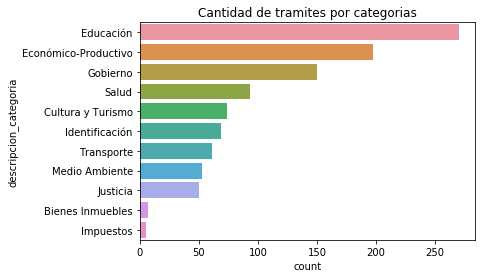

In [234]:
grafico = sns.countplot(y='descripcion_categoria', data=tramites, order=tramites['descripcion_categoria'].value_counts().index)
grafico.set_title('Cantidad de tramites por categorias')

In [94]:
print(tramites['moneda_costo'].value_counts())
def montoEnBolivianos(monto, moneda):
    # Convirtiendo todos los montos a Bolivianos
    # Bs2,33950  por unidad de UFV (consultado el 14 de Marzo de 2020 en https://www.bcb.gob.bo/?q=servicios/ufv/datos_estadisticos
    ufv_en_bolivianos = 2.33950
    dolar_en_bolivianos = 6.86
    if moneda == 'BS':
        return monto
    if moneda == 'UFV':
        return monto*ufv_en_bolivianos
    if moneda == 'SUS':
        return monto*dolar_en_bolivianos

#print(tramites.apply(lambda fila: montoEnBolivianos(fila['monto_costo'], fila['moneda_costo']), axis=1))
tramites['monto_bs'] = np.vectorize(montoEnBolivianos)(tramites['monto_costo'], tramites['moneda_costo'])

BS     814
UFV    170
SUS     45
Name: moneda_costo, dtype: int64


[Text(0, 0, 'Económico-Productivo'),
 Text(0, 0, 'Educación'),
 Text(0, 0, 'Cultura y Turismo'),
 Text(0, 0, 'Identificación'),
 Text(0, 0, 'Gobierno'),
 Text(0, 0, 'Salud'),
 Text(0, 0, 'Transporte'),
 Text(0, 0, 'Medio Ambiente'),
 Text(0, 0, 'Justicia'),
 Text(0, 0, 'Bienes Inmuebles'),
 Text(0, 0, 'Impuestos')]

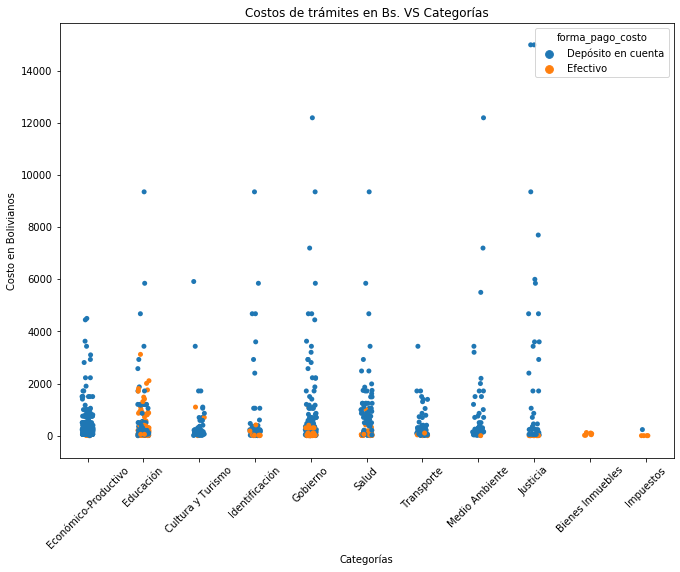

In [145]:
#plt.figure(figsize=(10,7))
fig, ax = plt.subplots(figsize=(11, 8))
grafico = sns.stripplot(y='monto_bs', x='descripcion_categoria', hue='forma_pago_costo', data=tramites)
ax.set(xlabel="Categorías", ylabel="Costo en Bolivianos")
grafico.set_title('Costos de trámites en Bs. VS Categorías')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)

El gráfico anterior muestra los montos de pagos en bolivianos de los trámites por categorías y la forma de pago.

[Text(0, 0, 'Económico-Productivo'),
 Text(0, 0, 'Educación'),
 Text(0, 0, 'Cultura y Turismo'),
 Text(0, 0, 'Identificación'),
 Text(0, 0, 'Gobierno'),
 Text(0, 0, 'Salud'),
 Text(0, 0, 'Transporte'),
 Text(0, 0, 'Medio Ambiente'),
 Text(0, 0, 'Justicia'),
 Text(0, 0, 'Bienes Inmuebles'),
 Text(0, 0, 'Impuestos')]

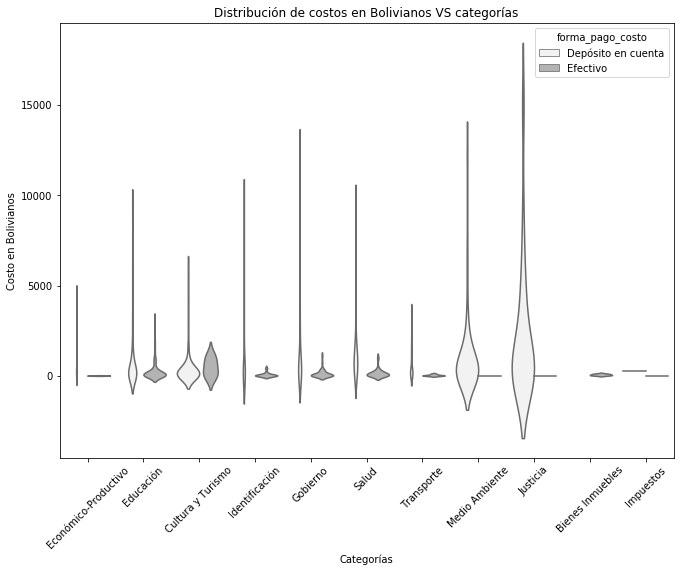

In [146]:
fig, ax = plt.subplots(figsize=(11, 8))
grafico = sns.violinplot(y='monto_bs', x='descripcion_categoria', hue='forma_pago_costo', data=tramites,
                         inner=None, color="0.7")
ax.set(xlabel="Categorías", ylabel="Costo en Bolivianos")
grafico.set_title('Distribución de costos en Bolivianos VS categorías')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)

El gráfico anterior muestra la distribución de montos de pagos por categorías, donde las las partes más ensanchadas denotan una mayor acumulación de cantidad de trámites que tienen un costo similar en bolivianos.

In [97]:
import re
def cleanHTMLTags(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, ' ', raw_html)
    return cleantext
tramites['procedimientos'] = tramites['procedimientos'].astype('str')
# eliminando tags html. solo tomando en cuenta el texto
tramites['procedimientos'] = tramites['procedimientos'].apply(cleanHTMLTags)
tramites['procedimientos']

0         Recepciona la solicitud de registro de laUni...
1         1.        Apersonarse a ventanilla de inform...
2         Apersonarse a ventanilla de informaciones de...
3         1.       El interesado presenta nota dirigid...
4         1.        Apersonarse a ventanilla de inform...
                              ...                        
1024      Realizar los pagos correspondientes en Banco...
1025      1.        Apersonarse a ventanilla de inform...
1026      1.        Apersonarse a ventanilla de inform...
1027                                                  nan
1028                                                  nan
Name: procedimientos, Length: 1029, dtype: object

In [98]:
tramites['procedimientos_len'] = tramites['procedimientos'].apply(len)

[Text(0, 0, 'Económico-Productivo'),
 Text(0, 0, 'Educación'),
 Text(0, 0, 'Cultura y Turismo'),
 Text(0, 0, 'Identificación'),
 Text(0, 0, 'Gobierno'),
 Text(0, 0, 'Salud'),
 Text(0, 0, 'Transporte'),
 Text(0, 0, 'Medio Ambiente'),
 Text(0, 0, 'Justicia'),
 Text(0, 0, 'Bienes Inmuebles'),
 Text(0, 0, 'Impuestos')]

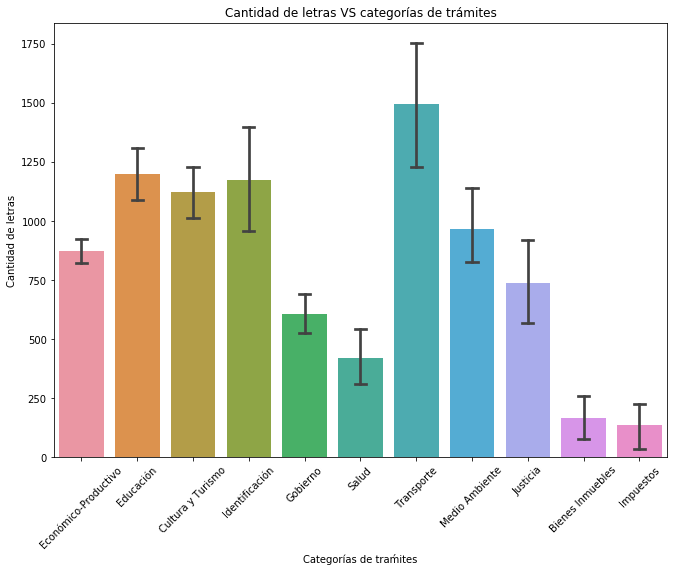

In [161]:
fig, ax = plt.subplots(figsize=(11, 8))
grafico = sns.barplot(y='procedimientos_len', x='descripcion_categoria', ax=ax, data=tramites, capsize=.2)
grafico.set_title('Cantidad de letras VS categorías de trámites')
ax.set(xlabel='Categorías de traḿites', ylabel='Cantidad de letras')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)

En este gráfico muestra por ejemplo que la categoría transporte, los trámites tienen una descripción con una cantidad promedio de letras de casi 1500.

Esto **podría significar** que existe **mucha burocracia** en esta categoría por que posiblemente se requiren muchos pasos para completar el trámite.

(357, 3)
0.0    111
5.0     30
4.0     24
1.0     17
2.0     11
3.0     10
Name: valoracion, dtype: int64


[Text(0, 0, 'Económico-Productivo'),
 Text(0, 0, 'Educación'),
 Text(0, 0, 'Cultura y Turismo'),
 Text(0, 0, 'Identificación'),
 Text(0, 0, 'Gobierno'),
 Text(0, 0, 'Transporte'),
 Text(0, 0, 'Salud'),
 Text(0, 0, 'Medio Ambiente')]

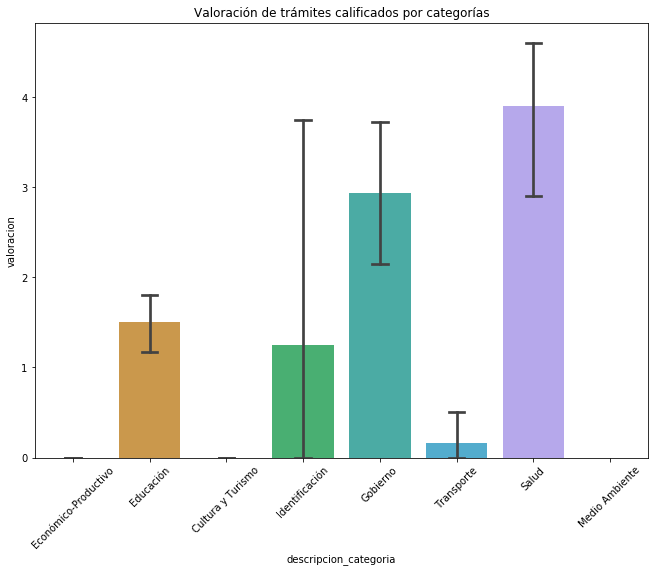

In [233]:
# Ahora analizaremos la valoracion de los tramites por categorias
df_valoracion = tramites[tramites['valoracion'].isna() == False][['descripcion_categoria','titulo_tramite', 'valoracion']]
print(df_valoracion.shape)

# quitando filas repetidas
df_valoracion = df_valoracion.loc[~df_valoracion['titulo_tramite'].duplicated(keep='first')]
print(df_valoracion['valoracion'].value_counts())

fig, ax = plt.subplots(figsize=(11, 8))
grafico = sns.barplot(y='valoracion', x='descripcion_categoria', ax=ax, data=df_valoracion, capsize=.2)
grafico.set_title('Valoración de trámites calificados por categorías')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45)

### Aplicación de la técnica apriori
Del conjunto de datos se usarán las columnas `titulo_tramite` y `descripcion_categoria` esto por que las diferentes categorías a las que pertenece un trámite se agrupan por el título del trámite. Tomando en cuenta esta agrupación podemos ajustar para aplicar el algoritmo apriori.

In [221]:
# seleccionando solo dos columnas en este 
dtt = tramites[['titulo_tramite', 'descripcion_categoria']]
del dtt['titulo_tramite']
print(dtt['descripcion_categoria'].unique())
print(dtt.shape)
# print('drop:', dtt.dropna())
print(dtt.shape)
# le = LabelEncoder()
# dtt2 = dtt.apply(le.fit_transform)
# dtt2
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(dtt)
# onehotlabels = enc.transform(dtt)
# c = onehotlabels.toarray()
# categorias_one = pd.DataFrame(columns=dtt['descripcion_categoria'].unique(), data=c)
# categorias_one[100:120]
#categorias_one.join(dtt['descripcion_categoria'].unique())

['Económico-Productivo' 'Educación' 'Cultura y Turismo' 'Identificación'
 'Gobierno' 'Salud' 'Transporte' 'Medio Ambiente' 'Justicia'
 'Bienes Inmuebles' 'Impuestos']
(1029, 1)
(1029, 1)


In [223]:
# Asegurando la conversion de los datos a cadenas sin espacios en blanco al inicio y final
tramites['descripcion_categoria'] = tramites['descripcion_categoria'].str.strip() 
tramites['titulo_tramite'] = tramites['titulo_tramite'].astype('str')
tramites['descripcion_categoria'] = tramites['descripcion_categoria'].astype('str')

In [224]:
# agrupamos los tramites por titulo_tramite y descripcion_categoria, luego se aplica unstack y reset_index para llenar con NaN
# las categorias a las que no pertenece un trámite, finalmente se reemplaza los valores NaN con 0 para aplicar onehot encoding
dd1 = (tramites.groupby(['titulo_tramite', 'descripcion_categoria'])['descripcion_categoria']
       .sum().unstack().reset_index().fillna(0).set_index('titulo_tramite'))
dd1

descripcion_categoria                              Bienes Inmuebles  \
titulo_tramite                                                        
ACTA DE DEFENSA FORMAL  DE MODALIDADES DE GRADU...                0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) Y/O APELLIDO ...                0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) y  /O APELLID...                0   
ADJUDICACIÓN                                                      0   
AVANCE (DE TERRENO POR MAYOR DERECHO)                             0   
...                                                             ...   
registro nacional de profesionales - nivel b, s...                0   
registro nacional de profesionales - nivel c, s...                0   
registro y acreditacion  de unidades productivas                  0   
remolque/semirremolque (emplaque y otorgación d...                0   
solicitud de certificados forestales de origen                    0   

descripcion_categoria                              Cultura y Turismo  \
titulo_tramite                                                         
ACTA DE DEFENSA FORMAL  DE MODALIDADES DE GRADU...                 0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) Y/O APELLIDO ...                 0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) y  /O APELLID...                 0   
ADJUDICACIÓN                                                       0   
AVANCE (DE TERRENO POR MAYOR DERECHO)                              0   
...                                                              ...   
registro nacional de profesionales - nivel b, s...                 0   
registro nacional de profesionales - nivel c, s...                 0   
registro y acreditacion  de unidades productivas                   0   
remolque/semirremolque (emplaque y otorgación d...                 0   
solicitud de certificados forestales de origen                     0   

descripcion_categoria                               Económico-Productivo  \
titulo_tramite                                                             
ACTA DE DEFENSA FORMAL  DE MODALIDADES DE GRADU...                     0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) Y/O APELLIDO ...                     0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) y  /O APELLID...                     0   
ADJUDICACIÓN                                                           0   
AVANCE (DE TERRENO POR MAYOR DERECHO)                                  0   
...                                                                  ...   
registro nacional de profesionales - nivel b, s...  Económico-Productivo   
registro nacional de profesionales - nivel c, s...  Económico-Productivo   
registro y acreditacion  de unidades productivas    Económico-Productivo   
remolque/semirremolque (emplaque y otorgación d...                     0   
solicitud de certificados forestales de origen                         0   

descripcion_categoria                               Educación  \
titulo_tramite                                                  
ACTA DE DEFENSA FORMAL  DE MODALIDADES DE GRADU...  Educación   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) Y/O APELLIDO ...  Educación   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) y  /O APELLID...  Educación   
ADJUDICACIÓN                                                0   
AVANCE (DE TERRENO POR MAYOR DERECHO)                       0   
...                                                       ...   
registro nacional de profesionales - nivel b, s...          0   
registro nacional de profesionales - nivel c, s...          0   
registro y acreditacion  de unidades productivas            0   
remolque/semirremolque (emplaque y otorgación d...          0   
solicitud de certificados forestales de origen              0   

descripcion_categoria                                                                        Gobierno  \
titulo_tramite                                                                                          
ACTA DE DEFENSA FORMAL  DE MODALIDADES DE GRADU...                                            

In [225]:
# definiedo hot_encode
def hot_encode(x):
    if(str(x) == '0'):
        return 0
    return 1;
# aplicando hot_encode
dd1_encoded = dd1.applymap(hot_encode)
dd1_encoded    

descripcion_categoria                               Bienes Inmuebles  \
titulo_tramite                                                         
ACTA DE DEFENSA FORMAL  DE MODALIDADES DE GRADU...                 0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) Y/O APELLIDO ...                 0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) y  /O APELLID...                 0   
ADJUDICACIÓN                                                       0   
AVANCE (DE TERRENO POR MAYOR DERECHO)                              0   
...                                                              ...   
registro nacional de profesionales - nivel b, s...                 0   
registro nacional de profesionales - nivel c, s...                 0   
registro y acreditacion  de unidades productivas                   0   
remolque/semirremolque (emplaque y otorgación d...                 0   
solicitud de certificados forestales de origen                     0   

descripcion_categoria                               Cultura y Turismo  \
titulo_tramite                                                          
ACTA DE DEFENSA FORMAL  DE MODALIDADES DE GRADU...                  0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) Y/O APELLIDO ...                  0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) y  /O APELLID...                  0   
ADJUDICACIÓN                                                        0   
AVANCE (DE TERRENO POR MAYOR DERECHO)                               0   
...                                                               ...   
registro nacional de profesionales - nivel b, s...                  0   
registro nacional de profesionales - nivel c, s...                  0   
registro y acreditacion  de unidades productivas                    0   
remolque/semirremolque (emplaque y otorgación d...                  0   
solicitud de certificados forestales de origen                      0   

descripcion_categoria                               Económico-Productivo  \
titulo_tramite                                                             
ACTA DE DEFENSA FORMAL  DE MODALIDADES DE GRADU...                     0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) Y/O APELLIDO ...                     0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) y  /O APELLID...                     0   
ADJUDICACIÓN                                                           0   
AVANCE (DE TERRENO POR MAYOR DERECHO)                                  0   
...                                                                  ...   
registro nacional de profesionales - nivel b, s...                     1   
registro nacional de profesionales - nivel c, s...                     1   
registro y acreditacion  de unidades productivas                       1   
remolque/semirremolque (emplaque y otorgación d...                     0   
solicitud de certificados forestales de origen                         0   

descripcion_categoria                               Educación  Gobierno  \
titulo_tramite                                                            
ACTA DE DEFENSA FORMAL  DE MODALIDADES DE GRADU...          1         0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) Y/O APELLIDO ...          1         0   
ADICIÓN O SUPRESIÓN DE NOMBRE (S) y  /O APELLID...          1         0   
ADJUDICACIÓN                                                0         1   
AVANCE (DE TERRENO POR MAYOR DERECHO)                       0         1   
...                                                       ...       ...   
registro nacional de profesionales - nivel b, s...          0         0   
registro nacional de profesionales - nivel c, s...          0         0   
registro y acreditacion  de unidades productivas            0         0   
remolque/semirremolque (emplaque y otorgación d...          0         0   
solicitud de certificados forestales de origen              0         1   

descripcion_categoria                               Identificación  Impuestos  \
titulo_tramite                                                     

In [226]:
# Construyendo el modelo
freq_items = apriori(dd1_encoded, min_support = 0.04, use_colnames=True)

# Recolectando los reglas inferidas en un dataframe
reglas = association_rules(freq_items, metric = 'lift', min_threshold = 1)
reglas = reglas.sort_values(['confidence', 'lift'], ascending = [False, False])
reglas

antecedents  \
6          (Económico-Productivo, Educación)   
5             (Cultura y Turismo, Educación)   
4  (Cultura y Turismo, Económico-Productivo)   
0                        (Cultura y Turismo)   
2                        (Cultura y Turismo)   
7                        (Cultura y Turismo)   
1                     (Económico-Productivo)   
8                     (Económico-Productivo)   
3                                (Educación)   
9                                (Educación)   

                                 consequents  antecedent support  \
6                        (Cultura y Turismo)            0.044397   
5                     (Económico-Productivo)            0.046512   
4                                (Educación)            0.046512   
0                     (Económico-Productivo)            0.082452   
2                                (Educación)            0.082452   
7          (Económico-Productivo, Educación)            0.082452   
1                        (Cultura y Turismo)            0.224101   
8             (Cultura y Turismo, Educación)            0.224101   
3                        (Cultura y Turismo)            0.456660   
9  (Cultura y Turismo, Económico-Productivo)            0.456660   

   consequent support   support  confidence       lift  leverage  conviction  
6            0.082452  0.044397    1.000000  12.128205  0.040737         inf  
5            0.224101  0.044397    0.954545   4.259434  0.033974   17.069767  
4            0.456660  0.044397    0.954545   2.090278  0.023157   11.953488  
0            0.224101  0.046512    0.564103   2.517175  0.028034    1.780002  
2            0.456660  0.046512    0.564103   1.235280  0.008859    1.246487  
7            0.044397  0.044397    0.538462  12.128205  0.040737    2.070472  
1            0.082452  0.046512    0.207547   2.517175  0.028034    1.157858  
8            0.046512  0.044397    0.198113   4.259434  0.033974    1.189056  
3            0.082452  0.046512    0.101852   1.235280  0.008859    1.021599  
9            0.046512  0.044397    0.097222   2.090278  0.023157    1.056172

Las reglas de asociación obtenidas muestran algunas relaciones que describiremos a continuación:

- Cuando un trámite pertenece a la categoría **Económico productivo** y **Educación**, hay un incremento de probabilidad de 11.12 veces de que también pertenezca a la categoría **Cultura y turismo**.
- Cuando un trámite pertence a las categorías **Cultura y turismo** y **Educación** se incrementan en 3.25 veces las probabilidades de que también pertenezca a **Económico productivo**.
- Cuando un trámite pertenece solamente a **Justicia**, hay 2.2 veces más probabilidad de que también pertenezca a **Gobierno**.

Esta información puede servir para identificar relaciones entre tipos de trámites y hacer por ejemplo mejores clasificaciones en el portal de trámites https://gob.bo. La fuerte relación entre Economía, educación y cultura y turismo indica que estas áreas tienen trámites que probablemente cumplen objetivos similares y quizá podrían unirse y reducir la cantidad de trámites necesarios para cumplir esos mismo objetivos.

### Trabajo posterior

Se puede mejorar y profundizar el análisis de los datos del portal único de trámites, este análisis es superficial y se ha completado un 14 de Febrero de 2020.

- Este portal esta en constante actualización ya que se incrementan las valoraciones por trámites, se actualiza la información y se agregan nuevos trámites.
- Existen campos como duración de trámites donde pocos tienen datos.
- Se puede analizar datos relacionados a entidades específicas y otros de las 49 columnas que contiene este conjunto de datos por cada trámite.